In [3]:
import pandas as pd
import numpy as np
import boto3
import sagemaker



        Date  Temp
0 1981-01-01  20.7
1 1981-01-02  17.9


<AxesSubplot:xlabel='Date'>

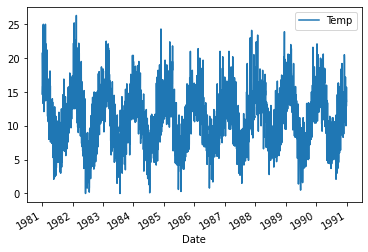

In [17]:
local_path = "data/min_temperature.csv"
data = pd.read_csv(local_path, parse_dates=['Date'])
print(data.head(2))
data.set_index('Date').plot()

In [18]:
s3 = boto3.resource("s3")

base_uri = f"s3://sagemaker-example-temperature/data"
input_data_uri = sagemaker.s3.S3Uploader.upload(
    local_path=local_path,
    desired_s3_uri=base_uri,
)
print(input_data_uri)

s3://sagemaker-example-temperature/data/min_temperature.csv


In [24]:
region = boto3.Session().region_name
sagemaker_session = sagemaker.session.Session()
iam_client = boto3.client('iam')
role = iam_client.get_role(RoleName='AmazonSageMaker-ExecutionRole-20220812T224878')['Role']['Arn']
default_bucket = sagemaker_session.default_bucket()
model_package_group_name = f"TemperatureModelPackageGroupName"

# pipeline params

In [29]:
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)

processing_instance_count = ParameterInteger(name="ProcessingInstanceCount", default_value=1)

processing_instance_type = ParameterString(
    name="ProcessingInstanceType", default_value="ml.t3.medium"
)

training_instance_type = ParameterString(name="TrainingInstanceType", default_value="ml.t3.medium")

input_data = ParameterString(
    name="InputData",
    default_value=input_data_uri,
)


# step 1 - fe

In [21]:
%%writefile steps/feature_engineering.py
import pandas as pd
import numpy as np

def create_time_features(data):
    data['year'] = data['Date'].dt.year
    data['month'] = data['Date'].dt.month
    data['day'] = data['Date'].dt.day
    data['dayofyear'] = data['Date'].dt.dayofyear
    data['total_days'] = pd.to_datetime(data['Date'].dt.year.astype(str) + '-12-31').dt.dayofyear
    data['cyclic_month'] = np.cos(2 * 3.14 * data['dayofyear'] / data['total_days']) / 2 + 0.5
    data['cyclic_month'] = data['cyclic_month'].round(decimals=2)
    data = data.drop(columns=['dayofyear', 'total_days'])
    return data

if __name__ == "__main__":
    base_dir = "/opt/ml/processing"

    data = pd.read_csv(
        f"{base_dir}/input/min_temperature.csv",
        parse_dates=['Date']
    )
    
    data = create_time_features(data)

    data[data['Date']<'1990-11-01'].to_csv(f"{base_dir}/train/train.csv", index=False)
    data[data['Date'].between('1990-11-01','1990-12-01')].to_csv(f"{base_dir}/validation/validation.csv", index=False)
    data[data['Date']>='1990-12-01'].to_csv(f"{base_dir}/test/test.csv", index=False)

Writing steps/feature_engineering.py


In [28]:
from sagemaker.sklearn.processing import SKLearnProcessor
sklearn_processor = SKLearnProcessor(
    framework_version="0.23-1",
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name="sklearn-abalone-process",
    role=role,
)

from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep
step_process = ProcessingStep(
    name="FeatureEngineering",
    processor=sklearn_processor,
    inputs=[
        ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
    ],
    outputs=[
        ProcessingOutput(output_name="train", source="/opt/ml/processing/train"),
        ProcessingOutput(output_name="validation", source="/opt/ml/processing/validation"),
        ProcessingOutput(output_name="test", source="/opt/ml/processing/test"),
    ],
    code="steps/feature_engineering.py",
)

# step 2.1 - lm learner - trend

# step 2.2 - lm learner - yearly cycle

# step 2.3 - prophet learner

# step 3 - xgb ensemble 

# pipeline

In [31]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = "TemperaturePipeline"
pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        processing_instance_type,
        processing_instance_count,
        training_instance_type,
        input_data,
    ],
    steps=[step_process],
)

import json
definition = json.loads(pipeline.definition())
definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [{'Name': 'ProcessingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.t3.medium'},
  {'Name': 'ProcessingInstanceCount', 'Type': 'Integer', 'DefaultValue': 1},
  {'Name': 'TrainingInstanceType',
   'Type': 'String',
   'DefaultValue': 'ml.t3.medium'},
  {'Name': 'InputData',
   'Type': 'String',
   'DefaultValue': 's3://sagemaker-example-temperature/data/min_temperature.csv'}],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'FeatureEngineering',
   'Type': 'Processing',
   'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.t3.medium',
      'InstanceCount': 1,
      'VolumeSizeInGB': 30}},
    'AppSpecification': {'ImageUri': '783357654285.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-scikit-learn:0.23-1-cpu-py3',
     'ContainerEntrypoint': ['python3',
      '/opt/ml/processing/in

In [32]:
pipeline.upsert(role_arn=role)
execution = pipeline.start()
execution.describe()
execution.wait()
execution.list_steps()

WaiterError: Waiter PipelineExecutionComplete failed: Waiter encountered a terminal failure state: For expression "PipelineExecutionStatus" we matched expected path: "Failed"